# OpenSpiro Algorithm Development

## Audio File Signal Analysis

##### Import Statements 

In [1]:
from IPython.display import Javascript, display
import numpy as np
import json
from matplotlib import pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from ipywidgets import widgets  

/Users/Spencer/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


##### Notebook Customization

In [2]:
# Forces graphs to display in notebook
%matplotlib inline

##### Global Functions

In [3]:
def get_max_values (data, frequency_threshold = 0, sampling_rate = 0):    
    # Match the frequency threshold to an index in each column
    threshold_index = 0
    if frequency_threshold > 0 and sampling_rate > 0:
        threshold_index = frequency_threshold / ((sampling_rate / 2) / data.shape[0])
    
    # Create a magnitude threshold which prevents low values from breaking up curves
    magnitude_threshold = 0.00005 * data.max()
    
    # Create an empty array of the same length as the data array
    max_array = np.zeros(data.shape[1])
    
    # Iterate through all columns of the FFT data
    previous_max_location = 0
    for i in range(0, data.shape[1]):
        col = data[threshold_index :, i]
        max_location = np.argmax(col) + threshold_index
        if data[max_location, i] < magnitude_threshold:
            max_location = previous_max_location
        max_array[i] = max_location   #Location of the highest value, not the value itself    
        previous_max_location = max_location
    return max_array

In [4]:
def convert_to_freq(index):
    return index*sample_rate/fft_n

In [5]:
def time_to_index(time, sampling_rate):    
    return int(float(time) * float(sampling_rate))

def index_to_time(index, sampling_rate):    
    return float(index) / float(sampling_rate)

##### Audio Variables

In [6]:
# Global variables for use by dropdown call-back
global sampling_rate, raw_data, sampling_rate_columns
# Original sampling rate divided by overlap since there will be a new window every [fft_shift] points 
# https://db.tt/4lOSyLeO 

# FFT Variables
# Number of points in each FFT window
fft_n = 2048

# Number of points each subsequent window is shifted
fft_shift = 128

In [7]:
# Open JSON file containing info about audio files
with open('audio_curve_data/105.json') as audio_data_json:    
    audio_files_data = json.load(audio_data_json)

# Retrieve the name of all audio files for dropdown
tests = audio_files_data['Tests']
audio_files = {}
for i in range(0, len(tests) - 1):
    # IGNORE ALL YELLOW SIDESTACK TESTS
    if tests[i]['Sidestack'] != 'Sidestack C (Yellow)':
        test = tests[i]
        efforts = test['Efforts']
        for j in range(0, len(efforts) - 1):
            effort = efforts[j]
            effort_data = {}
            file_name = effort['RecordedAudioFilenameForEffort']
            sidestack = str(i) +'_' + str(j) + ' ' + test['Sidestack']
            audio_files[sidestack] = file_name


# DEFAULT AUDIO FILE - If this file is changed, change the default file shown by the dropdown as well
# Import data from an audio file, save sampling rate and raw data
default_file = '1459410121.675097.wav'
            
# Create UI element for selecting waveform file
json_selector = widgets.Dropdown(
    options=audio_files,
    description='Waveform File:',
    value=default_file
)

display(json_selector)

def on_value_change(change):
    print("audio_curve_data/"+change['new'], change['name'])
    update_data(change['new'])
    
def update_data(file):
    global sampling_rate, raw_data, sampling_rate_columns
    sampling_rate, raw_data = wavfile.read("audio_curve_data/" + file)
    sampling_rate_columns = sampling_rate / fft_shift
    display(Javascript('IPython.notebook.execute_cells_below()'))
    print 'File:', json_selector.value
    
json_selector.observe(on_value_change, names='value')

update_data(json_selector.value)

/Users/Spencer/anaconda/lib/python2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


<IPython.core.display.Javascript object>

File: 1459410121.675097.wav


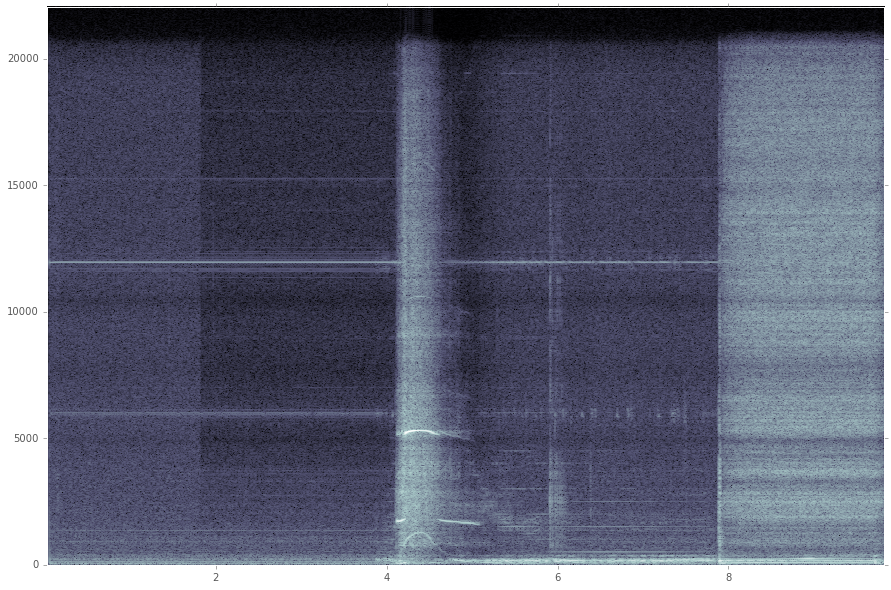

In [8]:
# Plot the raw spectrogram of the audio data 
f = plt.figure(figsize=(15,10)) 
plt.style.use('ggplot') 
 
data, data_freq, data_time, _ = plt.specgram(raw_data, NFFT=fft_n, Fs=sampling_rate, noverlap=(fft_n-fft_shift) ) 
# data_freq is a single column with the same number of rows as data where each row is a frequency (0 - fs/2) 
# data_time is an array of columns the same length as data where each index contains the time value at that column (0 - ~19) 
data[data==0] = 0.0001 
    
 
# Clear original figure 
f.clear() 
 
# Plot a customized figure 
ax = plt.subplot(1,1,1) 
ax.pcolorfast(data_time, data_freq, np.log(data+0.00001), cmap=plt.cm.bone) 
plt.grid()

3.64625112541


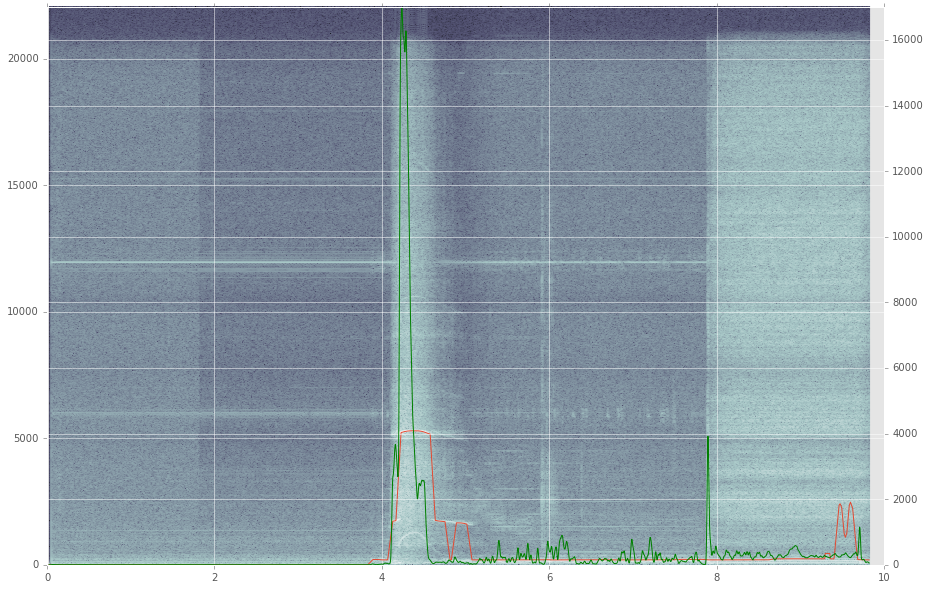

In [9]:
# Plot Modification
f = plt.figure(figsize=(15,10))
plt.style.use('ggplot')

frequency_threshold = 200
max_values = get_max_values(data, frequency_threshold, sampling_rate)

med_window_length = 31
max_values = medfilt(max_values, med_window_length)

sg_window_length = 21
poly_order = 1
max_values = savgol_filter(max_values, sg_window_length, poly_order, mode='mirror')


ax = plt.subplot(1,1,1)
ax.pcolorfast(data_time, data_freq, np.log(data), cmap=plt.cm.bone)
ax.plot(data_time, max_values*sampling_rate/fft_n)
# max_values is a 1D array containing the vertical index which represents the max value for any given slice
# ... because this value is NOT a frequency, we must map it to the correct frequency by multiplying the value by 
# ... sampling_rate/fft_n which is generated by the following:
# ... The FFT returns a symmetric graph from 0 to fft_n, but because it's symmetric, half must be removed (fft_n/2)
# ... then to map a frequency to an index, the sampling rate must be divided by 2 (fs/2)... finally, to map the two,
# ... any index from fft_n/2 must be mapped to fs/2, resuling in fs/2 ÷ fft_n/2 OR fs/fft_n

# Calculate the overall energy by summing each column
cols = 0
db_data = np.log(data[(data_freq>200) & (data_freq<4000),:]) 
energy = np.max(db_data,axis=cols)
db_min = np.percentile(energy,10)
print db_min
energy = energy - db_min

energy = np.mean(data, axis=cols)

# Graph it on top of the spectrogram
ax2 = ax.twinx()
plt.ylim(0, max(energy))
ax2.plot(data_time, energy, 'g')

## Feature Extraction

##### Variable Declaration

In [10]:
# Create variables for various features (curves)

# Curve which will be used for the analysis
data_curve = max_values*sampling_rate/fft_n
# The data is multiplied by the sampling_rate/fft_n to map y-indices to frequencies

# whistle_endpoints: the whistle at the beginning and end of the test
whistle_endpoints = np.empty(data.shape[1])
whistle_endpoints[:] = np.nan

# whistle_midsection: the whistle (during vortex) after jumping in frequency
whistle_midsection = np.empty(data.shape[1])
whistle_midsection[:] = np.nan

# whistle_combined_normalized: a curve combining all whistle components, including a normalized midsection
whistle_combined_normalized = np.empty(data.shape[1])
whistle_combined_normalized[:] = np.nan

# vortex_fundamental: a curve representing the extracted vortex curve
vortex_fundamental = np.empty(data.shape[1])
vortex_fundamental[:] = np.nan

# vortex_harmonics: an array for additional vortex harmonics (should they be detected)
vortex_harmonics = []

In [11]:
# Find point of max energy
max_energy = max(energy)
max_energy_loc = np.argmax(energy)
max_energy_time = index_to_time(max_energy_loc, sampling_rate_columns)

# Find # of index points in 1/2 second... create window of max_energy_location ± index
search_window_time = 0.5
search_window_shift = time_to_index(search_window_time, sampling_rate_columns)

search_window = data_curve[max_energy_loc - search_window_shift : max_energy_loc + search_window_shift]

# Search through window to find the temp point of max_magnitude

# Follow this curve within a band of ±20Hz and find end points to determine whistle mid-section

# Find actual max_magnitude point by taking the max of the whistle mid-section

# From beginning point, drop down to 1/3 of frequency then look for a highest magnitude within band of ± 20Hz

# Follow this point end to end to determine the beginning of the whistle

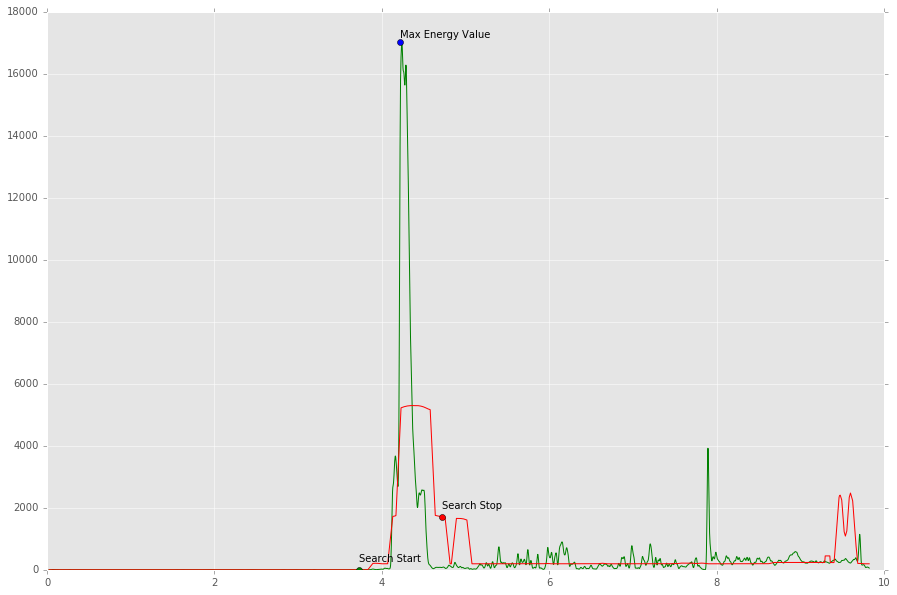

In [12]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(data_time, energy, 'g')
ax.plot(data_time, data_curve, 'r')


ax.plot(max_energy_time, energy[max_energy_loc], 'ob')
ax.text(max_energy_time, energy[max_energy_loc] + 0.01*max_energy, 'Max Energy Value')

ax.plot(max_energy_time - search_window_time, data_curve[max_energy_loc - search_window_shift], 'og')
ax.text(max_energy_time - search_window_time, data_curve[max_energy_loc - search_window_shift] + 250, 'Search Start')

ax.plot(max_energy_time + search_window_time, data_curve[max_energy_loc + search_window_shift], 'or')
ax.text(max_energy_time + search_window_time, data_curve[max_energy_loc + search_window_shift] + 250, 'Search Stop')

Find max energy, look within a window of ±0.5 seconds to try to find the max frequency
trace back/forward then look at 1/3 for whistle start/end


Feat 1: vortex curve (array with indices of highest magnitude along the curve)
Feat 2: side whistle ends
Feat 3: side whistle peak
Feat 4: feat 2 + (feat 3 / 2) [bring it down to it's harmonic; should be one smooth-ish line)

Reach:
Feat 5: Harmonic of vortex


Go point by point, when looking at next point, examing the max magnitude frequencies of the next index...
First threshold of 100Hz and play with it

- Find side whistle, create a new data array for whistle and it's indices, trace within band until end is found
- Create new data array for whistle harmonic and look at 3x band for whistle harmonic, trace back to beginning
- Trace harmonic till the end (within band)
- Look at 1/3 frequency for end of whistle band, trace back to beginning
- Follow whistle to end
- For any of these points, look for next point within a band of surrounding frequencies before moving elsewhere, if point within the band is > 85% of the actual max, continue within band


- Grab max frequency between frequency of whistle at the end of the beginning section and try to find the beginning of the curve. Keep finding max values in a band around the current frequency


- After finding vortex curve, examine 2nd through 10th harmonics to see if the mean of points in a band of ±10Hz are significantly higher than the mean of points within ±100Hz 

### Notes:
- matrices are indexed by row:column (e.g., data[:, 1] will return a tuple which contains all the rows for the column at index 1)